In [1]:
import pickle
import torch
import numpy as np
from StructuralProbe import StructuralProbe
from POSProbe import POSProbe
from collections import defaultdict
from tree_utils import calc_uuas
%load_ext autoreload
%autoreload 2
with open("FINALS.pickle", "rb") as f:
    result_dict = pickle.load(f)

In [127]:
from tree_utils import create_or_load_structural_data
import torch.utils.data as data
import math

from datasets import * 
device = 'cuda:0'
def mean_test_acc(the_dict):
    """Averages uuas score or accuracy on test set over three seeds"""
    three_accs = [the_dict[z]['test_acc'] for z in the_dict]
    return np.mean(three_accs), np.std(three_accs)

def mean_dev_acc(the_dict):
    """Averages uuas score or accuracy on dev set over three seeds"""
    three_accs = [the_dict[z]['dev_acc'] for z in the_dict]
    return np.mean(three_accs), np.std(three_accs)

def uuas_per_length(model, test_loader):
    length_amount_dict = defaultdict(lambda:0)
    length_uuas_dict = defaultdict(lambda:0)
    result = dict()
    model.eval()
    with torch.no_grad():
        for distances, embs, lengths in test_loader:
            embs = embs.to(device)
            distances = distances.to(device)
            lengths = lengths.to(device)

            embs = embs.to(device)
            distances = distances.to(device)
            lengths = lengths.to(device)
            outputs = model(embs)
            l = lengths[0].item()
            preds = outputs[0,0:l, 0:l]
            gold = distances[0,0:l, 0:l]

            u = calc_uuas(preds, gold)
            if not math.isnan(u):
                length_amount_dict[l] +=1
                length_uuas_dict[l] += u
    result2 = {}
    for k in sorted(list(length_uuas_dict.keys())):
        result[k] = length_uuas_dict[k]/length_amount_dict[k]
        result2[k] = result[k] / k
    #print([z for z in sorted(length_amount_dict.items())])
    #print([z for z in sorted(result.items())])
    return result, length_amount_dict


def uuas_length_averaged_per_seed(model, test_loader):
    """Collects uuas score per sentence length in a dict and averaged over three seeds"""
    result = defaultdict(lambda:0)
    result2 = defaultdict(lambda:0)
    for seed in [10,20,30]:
        specific_results, specific_results2 = uuas_per_length(model[seed]['state_dict'], test_loader)
        for k in specific_results:
            result[k] += specific_results[k]
            
        for k in specific_results2:
            result2[k] += specific_results2[k]
    for k in result:
        result[k] /=3 
        result2[k] /=3
    return result, result2

[0, 256] [0.888561258102221, 0.9026670917012006] [0.3450616300074383, 0.22169535649771532]
[0, 256] [0.9175565827223462, 0.9277574115396877] [0.3785729465519073, 0.2687413664860271]
[0, 256] [0.7709860801190097, 0.7953857188396557] [0.32816650727871644, 0.27303155881415364]
[0, 256] [0.8814552119859739, 0.8907926894060143] [0.35791892466262887, 0.2568271172032728]


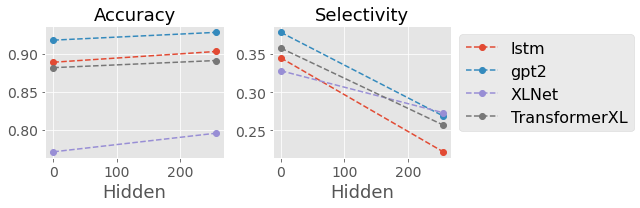

[16, 64, 128] [0.6346764236159084, 0.6717540982852755, 0.6657085194020865] [0.21339997839708547, 0.18495937536094836, 0.16516381806885583]
[16, 64, 128] [0.6446603328614812, 0.6549281926743292, 0.6467568253763222] [0.18630320720304322, 0.1501442359853704, 0.14160647331815324]
[16, 64, 128] [0.41060136464757274, 0.4253525171973796, 0.4228098173847052] [0.0865801882822757, 0.10604952522209848, 0.10676391487865494]
[16, 64, 128] [0.5786522184767026, 0.5920818066988821, 0.5845403471831317] [0.20149298310623254, 0.17967980331411065, 0.18050229268289436]


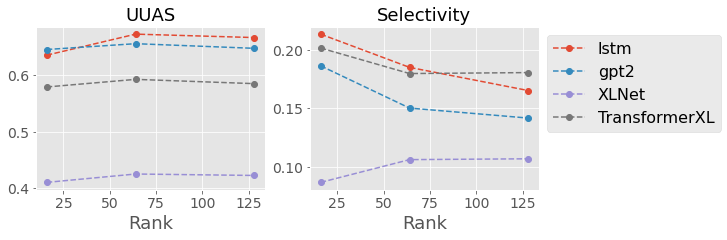

In [126]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

"""
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9,3))

for model in ['lstm', 'transformer', 'XLNet', 'TransformerXL']:
    for hidden_size in [256]:
        x_axis = [0,0.2,0.4,0.6,0.8]
        y_axis = []
        y_axis_control = []
        y_axis_select = []
        for d in x_axis :
            # Mean for POS task
            mean = mean_test_acc(result_dict['pos'][model][hidden_size][d])
            
            # Mean for Control task
            mean_control = mean_test_acc(result_dict['controlpos'][model][hidden_size][d])
            #print(model, mean, mean_control)
            # Append
            y_axis.append(mean[0])
            y_axis_select.append(mean[0] - mean_control[0])

        ax1.plot(x_axis, y_axis, '--o', label=model if model != 'transformer' else 'gpt2', )
        ax2.plot(x_axis, y_axis_select, '--o', label=model if model != 'transformer' else 'gpt2',)
        ax2.legend(fontsize=16, bbox_to_anchor=(1,1))
        
    
ax1.set_title("Accuracy", fontsize=18)
ax2.set_title("Selectivity", fontsize=18)
"""
#plt.tight_layout()
#plt.show()


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9,3))


for model in ['lstm', 'transformer', 'XLNet', 'TransformerXL']:
    for d in [0.2]:
        x_axis = []
        y_axis = []
        y_axis_control = []
        y_axis_select = []
        for hidden_size in [0,256] :
            # Mean for POS task
            mean = mean_test_acc(result_dict['pos'][model][hidden_size][d])
            
            # Mean for Control task
            mean_control = mean_test_acc(result_dict['controlpos'][model][hidden_size][d])
            #print(model, mean, mean_control)
            # Append
            x_axis.append(hidden_size)
            y_axis.append(mean[0])
            y_axis_select.append(mean[0] - mean_control[0])
        print(x_axis, y_axis, y_axis_select)
        ax1.plot(x_axis, y_axis, '--o', label=(model if model != 'transformer' else 'gpt2'), )
        ax2.plot(x_axis, y_axis_select, '--o', label=(model if model != 'transformer' else 'gpt2'),)
        ax2.legend(fontsize=16, bbox_to_anchor=(1,1))
        #ax1.set_ylim(0.3,0.8)
        #ax2.set_ylim(0.1,0.25)
    
ax1.set_title("Accuracy", fontsize=18)
ax2.set_title("Selectivity", fontsize=18)
ax1.set_xlabel("Hidden", fontsize=18)
ax2.set_xlabel("Hidden", fontsize=18)

plt.tight_layout()
plt.show()

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9,3))


for model in ['lstm', 'transformer', 'XLNet', 'TransformerXL']:
    for d in [0]:
        x_axis = []
        y_axis = []
        y_axis_control = []
        y_axis_select = []
        for hidden_size in [16,64,128] :
            # Mean for POS task
            mean = mean_test_acc(result_dict['dep'][model][hidden_size][d])
            
            # Mean for Control task
            mean_control = mean_test_acc(result_dict['controldep'][model][hidden_size][d])
            #print(model, mean, mean_control)
            # Append
            x_axis.append(hidden_size)
            y_axis.append(mean[0])
            y_axis_select.append(mean[0] - mean_control[0])
        print(x_axis, y_axis, y_axis_select)
        ax1.plot(x_axis, y_axis, '--o', label=(model if model != 'transformer' else 'gpt2'), )
        ax2.plot(x_axis, y_axis_select, '--o', label=(model if model != 'transformer' else 'gpt2'),)
        ax2.legend(fontsize=16, bbox_to_anchor=(1,1))
        #ax1.set_ylim(0.3,0.8)
        #ax2.set_ylim(0.1,0.25)
    
ax1.set_title("UUAS", fontsize=18)
ax2.set_title("Selectivity", fontsize=18)
ax1.set_xlabel("Rank", fontsize=18)
ax2.set_xlabel("Rank", fontsize=18)

plt.show()


In [96]:
result_dict['dep']['XLNet'][16][0]

{10: {'state_dict': StructuralProbe(
    (dropout): Dropout(p=0, inplace=False)
  ),
  'dev_acc': 0.4191334460112989,
  'test_acc': 0.4158114450473195,
  'epochs': 11},
 20: {'state_dict': StructuralProbe(
    (dropout): Dropout(p=0, inplace=False)
  ),
  'dev_acc': 0.4150395013903099,
  'test_acc': 0.4092016391180347,
  'epochs': 9},
 30: {'state_dict': StructuralProbe(
    (dropout): Dropout(p=0, inplace=False)
  ),
  'dev_acc': 0.41516261417250655,
  'test_acc': 0.40679100977736393,
  'epochs': 2}}

In [138]:
gpt2embs = create_or_load_structural_data("test", None, None, extra_transformer='GPT2')
lstmembs = create_or_load_structural_data("test", None, None, extra_transformer='RNN')
xlnetembs = create_or_load_structural_data("test", None, None, extra_transformer='XLNet')
transformerxlembs = create_or_load_structural_data("test", None, None, extra_transformer='TransformerXL')

test_loader_gpt2 = data.DataLoader(StructuralDataset(*gpt2embs), batch_size=1, shuffle=False)
test_loader_lstm = data.DataLoader(StructuralDataset(*lstmembs), batch_size=1, shuffle=False)
test_loader_xlnet = data.DataLoader(StructuralDataset(*xlnetembs), batch_size=1, shuffle=False)
test_loader_transformerxl = data.DataLoader(StructuralDataset(*transformerxlembs), batch_size=1, shuffle=False)

# 64,0 are best hyperparams for each
gpt2, ngpt2  = uuas_length_averaged_per_seed(result_dict['dep']['transformer'][64][0], test_loader_gpt2)
rnn, nrnn = uuas_length_averaged_per_seed(result_dict['dep']['lstm'][64][0], test_loader_lstm)
xlnet, nxlnet = uuas_length_averaged_per_seed(result_dict['dep']['XLNet'][64][0], test_loader_xlnet)
txl, ntxl = uuas_length_averaged_per_seed(result_dict['dep']['TransformerXL'][64][0], test_loader_transformerxl)

USING SAVE FILE corpus/transformer_structuraltest.pickle
USING SAVE FILE corpus/RNN_structuraltest.pickle
USING SAVE FILE corpus/transformer_structuraltest_XLNet.pickle
USING SAVE FILE corpus/transformer_structuraltest_TransformerXL.pickle


/home/anna/Documents/uni/nlp2/nlp2-probing-lms/tree_utils.py:125: RuntimeWarning: invalid value encountered in double_scalars
  uuas = np.sum([pred_edge in gold_edges for pred_edge in pred_edges]) / len(gold_edges)


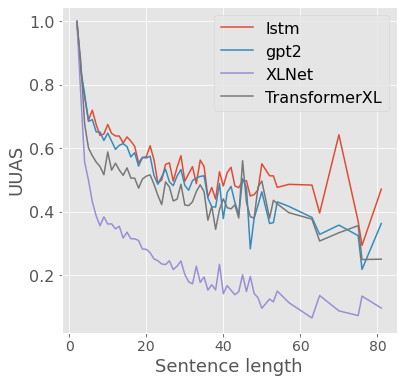

In [139]:

plt.style.use('ggplot')
fig, ax1 = plt.subplots(1,1, figsize=(6,6))

ax1.plot(*zip(*rnn.items()), label='lstm')
ax1.plot(*zip(*gpt2.items()), label='gpt2')
ax1.plot(*zip(*xlnet.items()), label='XLNet')
ax1.plot(*zip(*txl.items()), label='TransformerXL')

#ax2.plot(*zip(*ngpt2.items()), label='gpt2')
#ax2.plot(*zip(*nrnn.items()), label='lstm')
#ax2.plot(*zip(*nxlnet.items()), label='xlnet')
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

ax1.legend(fontsize=16,)
ax1.set_xlabel("Sentence length",fontsize=18)
ax1.set_ylabel("UUAS", fontsize=18)
plt.show()

In [141]:
import scipy.stats


def get_slope(modeldict):
    xs = np.array(list(modeldict.keys())[1:40])
    ys = np.array(list(modeldict.values())[1:40])
    return scipy.stats.linregress(xs, ys).slope

def decrease(modeldict):
    avg_acc1 = 0
    avg_acc2 = 0
    range1 = range(6,16)
    range2 = range(16,30)
    total_len = 0
    for i in range1 :
        avg_acc1 += modeldict[i] * nrnn[i]
        total_len += nrnn[i]
        
    total_len2 = 0
    for i in range2:
        avg_acc2 += modeldict[i] * nrnn[i] 
        total_len2 += nrnn[i]
    
    avg1 = avg_acc1/total_len
    avg2 = avg_acc2/total_len2
    #print('Percentage of short sentences', total_len/(total_len+total_len2))
    print('Short',round(avg1,3),'Long', round(avg2,3))
    print("Ratio", round(avg2/avg1,3))

print('gpt2', get_slope(gpt2))
decrease(gpt2)

print('rnn', get_slope(rnn))
decrease(rnn)

print('xlnet', get_slope(xlnet))
decrease(xlnet)


print('transformerxl', get_slope(txl))
decrease(txl)
    

gpt2 -0.007740880744526224
Short 0.638 Long 0.544
Ratio 0.852
rnn -0.006736174318483668
Short 0.658 Long 0.566
Ratio 0.861
xlnet -0.009411775514123442
Short 0.368 Long 0.272
Ratio 0.739
transformerxl -0.006381577122290277
Short 0.548 Long 0.485
Ratio 0.886


lstm pos 256 0.2
transformer pos 256 0.2
XLNet pos 256 0
TransformerXL pos 256 0.2
lstm dep 64 0
transformer dep 64 0
XLNet dep 64 0
TransformerXL dep 64 0


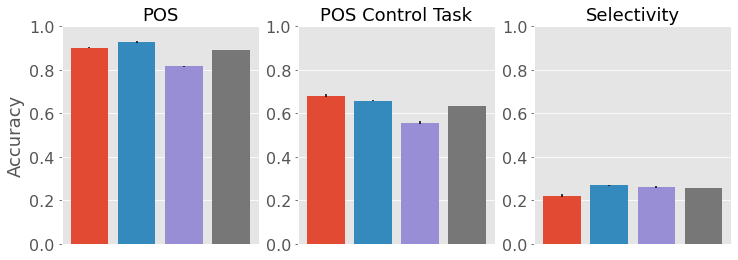

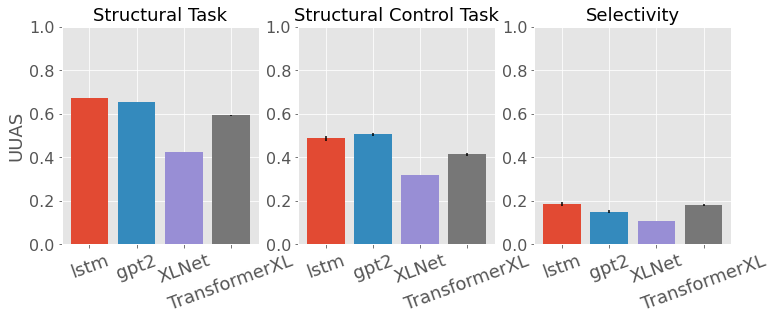

In [81]:
def find_best_dev_given_task_and_model(task, model):
    dim = [0,256] if 'pos' in task else [16,64,128]
    best_dev_acc = 0
    for hidden_size in dim:
        for dropout in [0,0.2,0.4,0.6,0.8]:
            dev_acc = mean_dev_acc(result_dict[task][model][hidden_size][dropout])[0]
            if dev_acc > best_dev_acc:
                best_hidden = hidden_size
                best_dropout = dropout
                best_dev_acc = dev_acc
    return best_hidden, best_dropout

plt.style.use('ggplot')
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))


for model in ['lstm', 'transformer','XLNet', 'TransformerXL']:
    task = 'pos'
    h, d = find_best_dev_given_task_and_model(task, model)
    print(model, task, h,d)
    mean, sd = mean_test_acc(result_dict[task][model][h][d])
    meanC, sdC = mean_test_acc(result_dict['controlpos'][model][h][d])
    if model == 'transformer': model = 'gpt2'
    
    ax1.bar(model, mean, yerr= sd, width=0.8)#, label='model')
    ax2.bar(model, meanC, yerr=sdC,width=0.8)#, label='model')
    ax3.bar(model, mean-meanC, yerr=sd-sdC, width=0.8)#,label='model')
ax1.set_title("POS", fontsize=18)
ax2.set_title("POS Control Task", fontsize=18)
ax3.set_title("Selectivity", fontsize=18)
ax1.set_ylabel("Accuracy", fontsize=18)
for ax in [ax1,ax2,ax3]:
    ax.set_xticks([])
    ax.set_ylim(0,1)
    #ax.tick_params(axis='x', rotation=20, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

#plt.tight_layout()
plt.savefig('pos.png', format='eps',  dpi=1200)
#plt.show()

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))

for model in ['lstm', 'transformer','XLNet', 'TransformerXL']:
    task = 'dep'
    h, d = find_best_dev_given_task_and_model(task, model)
    print(model, task, h,d)
    mean, sd = mean_test_acc(result_dict[task][model][h][d])
    meanC, sdC = mean_test_acc(result_dict['controldep'][model][h][d])
    if model == 'transformer': model = 'gpt2'
    
    ax1.bar(model, mean, yerr= sd, width=0.8, label='model')
    ax2.bar(model, meanC, yerr=sdC, width=0.8,label='model')
    ax3.bar(model, mean-meanC, yerr=sd-sdC,width=0.8, label='model')
    
ax1.set_title("Structural Task", fontsize=18)
ax2.set_title("Structural Control Task", fontsize=18)
ax3.set_title("Selectivity", fontsize=18)
ax1.set_ylabel("UUAS", fontsize=18)
    
for ax in [ax1,ax2,ax3]:
    ax.set_ylim(0,1)
    ax.tick_params(axis='x', rotation=20, labelsize=18)
    ax.tick_params(axis='y', labelsize=16)
plt.savefig('struct.eps', format='eps')
#plt.show()

In [ ]:
def find_best_dev_given_task_and_model(task, model):
    dim = [0,256] if 'pos' in task else [16,64,128]
    best_dev_acc = 0
    for hidden_size in dim:
        for dropout in [0,0.2,0.4,0.6,0.8]:
            dev_acc = mean_dev_acc(result_dict[task][model][hidden_size][dropout])[0]
            if dev_acc > best_dev_acc:
                best_hidden = hidden_size
                best_dropout = dropout
                best_dev_acc = dev_acc
    return best_hidden, best_dropout

plt.style.use('ggplot')
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))


for model in ['lstm', 'transformer','XLNet', 'TransformerXL']:
    task = 'pos'
    h, d = find_best_dev_given_task_and_model(task, model)
    print(model, task, h,d)
    mean, sd = mean_test_acc(result_dict[task][model][h][d])
    meanC, sdC = mean_test_acc(result_dict['controlpos'][model][h][d])
    if model == 'transformer': model = 'gpt2'
    
    ax1.bar(model, mean, yerr= sd, width=0.8, label='model')
    ax2.bar(model, meanC, yerr=sdC,width=0.8, label='model')
    ax3.bar(model, mean-meanC, yerr=sd-sdC, width=0.8,label='model')
ax1.set_title("POS", fontsize=18)
ax2.set_title("POS Control Task", fontsize=18)
ax3.set_title("Selectivity", fontsize=18)
ax1.set_ylabel("Accuracy", fontsize=16)
for ax in [ax1,ax2,ax3]:
    ax.set_ylim(0,1)
    ax.tick_params(axis='x', rotation=20, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

#plt.tight_layout()
plt.savefig('pos.png', format='eps',  dpi=1200)
#plt.show()

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))

for model in ['lstm', 'transformer','XLNet', 'TransformerXL']:
    task = 'dep'
    h, d = find_best_dev_given_task_and_model(task, model)
    print(model, task, h,d)
    mean, sd = mean_test_acc(result_dict[task][model][h][d])
    meanC, sdC = mean_test_acc(result_dict['controldep'][model][h][d])
    if model == 'transformer': model = 'gpt2'
    
    ax1.bar(model, mean, yerr= sd, width=0.8, label='model')
    ax2.bar(model, meanC, yerr=sdC, width=0.8,label='model')
    ax3.bar(model, mean-meanC, yerr=sd-sdC,width=0.8, label='model')
    
ax1.set_title("Structural Task", fontsize=18)
ax2.set_title("Structural Control Task", fontsize=18)
ax3.set_title("Selectivity", fontsize=18)
ax1.set_ylabel("UUAS", fontsize=16)
    
for ax in [ax1,ax2,ax3]:
    ax.set_ylim(0,1)
    ax.tick_params(axis='x', rotation=20, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
plt.savefig('struct.eps', format='eps')
#plt.show()